In the next cell we install the necessary dependancies.

In [ ]:
#install missing dependancies
!pip install transformers accelerate
!pip install wordcloud
!pip install bcolors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Then we will import the used Python Libraries. Additionally we connect to the Google drive,where the data we work with will be stored. We will also laod the BERT tokenier for tokenizing the sentences in the dataset. Notice that, since we use different pre-trained models, they are all going to have different tokenizersm which will give us slightly different tokens. So we need to load also the correct tokenizer depending on the model we are using. I will use for this exmaple presentation the "bert-base-uncased" model. Although the code was designed so that you can use any model by just changing the variable current_model

In [ ]:
# Pandas Dataframe Library
import json
import pandas as pd
import os
from IPython.display import display
import numpy as np 
from google.colab import drive


# Graphs and Charts
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

# needed for tokenization
from transformers import AutoTokenizer


bert="bert-base-uncased"
bert_cased="bert-base-cased"
HateBert="GroNLP/hateBERT"
DistilBert="distilbert-base-uncased"
RoBERTa="roberta-base" 
HateRoBERTa="facebook/roberta-hate-speech-dynabench-r4-target"
current_model=bert
tokenizer = AutoTokenizer.from_pretrained(current_model)


# Importing TextBlob
from textblob import TextBlob



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In the next cell all the function to analyse and visualize the dataset will be implemented.

In [ ]:
from IPython.core.interactiveshell import dis


# Function to get the polarity of text
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def overview_data(dataset):
  print("Look at example representative entries of the dataset")
  display(dataset.head(2))
  print("")
  
  if(dataset.isnull().values.any()):
    print("Dataset is not complete. Values are missing")
  else:
    print("Dataset complete")
  
  
  
  if(dataset.duplicated().any()):
    print("Duplicates Found. Duplicates removed.")
    dataset.drop_duplicates
  else:
    print("No Duplicates")

  print("How many values are in each column of the dataset?")
  display(dataset.count())
  print("")
  print("How balanced is the dataset?")
  display(dataset.label.value_counts(normalize=True))
  print("")


def visualize_overview_dataset(dataset):
  print("Look at example representative entries of the dataset")
  display(dataset.head(2))
  
  plt.title("All Samples (context+target) organized by Labels")
  ax= dataset.sort_values("label")["label"].value_counts(sort=False).plot(kind='bar', figsize=(10,10),color=['red','black','green'])
  plt.xlabel("Samples")
  plt.ylabel("Number of Samples ")
  ax.bar_label(ax.containers[0], label_type='edge')
  red_patch = mpatches.Patch(color='red', label='Hate Speech')
  black_patch = mpatches.Patch(color='black', label='Neutral Speech')
  green_patch = mpatches.Patch(color='green', label='Counter Hate Speech')
  plt.legend(handles=[red_patch, black_patch, green_patch ])
  plt.show


def wordcloud_target(dataset):
  wordcloud = WordCloud().generate(' '.join(dataset['target']))
  # Generate plot
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()
  
def wordcloud_context(dataset):
  wordcloud = WordCloud().generate(' '.join(dataset['context']))
  # Generate plot
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()


# helper function
def add_tokenization_encoding(dataset):
  tokens_c=[] # tokenization of the context sentences
  token_ids_c=[]  # tokenization ids or encoding of the context sentences
  length_of_token_ids_c=[] # length of the tokenization of the context sentences

  for sent in dataset.context:
    tokens = tokenizer.tokenize(sent)
    input_ids = tokenizer.encode(sent,add_special_tokens=True)
    tokens_c.append(tokens)
    token_ids_c.append(input_ids)
    length_of_token_ids_c.append(len(input_ids))
  dataset['tokens_c']= tokens_c  
  dataset['token_ids_c']= token_ids_c   
  dataset['length_of_token_ids_c']= length_of_token_ids_c 
  
 
  tokens_t=[] # tokenization of the target sentences
  token_ids_t=[]  # tokenization ids of encoding of the target sentences
  length_of_token_ids_t=[] # length of the tokenization of the target sentences

  for sent in dataset.target:
    tokens = tokenizer.tokenize(sent)
    input_ids = tokenizer.encode(sent,add_special_tokens=True)
    tokens_t.append(tokens)
    token_ids_t.append(input_ids)
    length_of_token_ids_t.append(len(input_ids))
  dataset['tokens_t']= tokens_t  
  dataset['token_ids_t']= token_ids_t   
  dataset['length_of_token_ids_t']= length_of_token_ids_t 
  



  tokens_ct=[] # tokenization of the context and target sentences
  token_ids_ct=[]  # tokenization ids of encoding of the context and target sentences
  length_of_token_ids_ct=[] # length of the tokenization of the context and target sentences

  for sent in dataset.context+dataset.target:
    tokens = tokenizer.tokenize(sent)
    input_ids = tokenizer.encode(sent,add_special_tokens=True)
    tokens_ct.append(tokens)
    token_ids_ct.append(input_ids)
    length_of_token_ids_ct.append(len(input_ids))
  dataset['tokens_ct']= tokens_ct  
  dataset['token_ids_ct']= token_ids_ct   
  dataset['length_of_token_ids_ct']= length_of_token_ids_ct 
  

def overview_tokenization(dataset):
  add_tokenization_encoding(dataset)
  display(dataset['length_of_token_ids_c'].describe([.25,.5,.75,0.8,0.95,0.99]))
  display(dataset['length_of_token_ids_t'].describe([.25,.5,.75,0.8,0.95,0.99]))
  display(dataset['length_of_token_ids_ct'].describe([.25,.5,.75,0.8,0.95,0.99]))
  print("")
  if(int(dataset['length_of_token_ids_ct'].max())>512):
    print("Sequence length is longer than the specified maximum sequence length (512) ")
    display(dataset.query('length_of_token_ids_ct > 512'))


def show_dataset_pie(l_train,l_val,l_test):
  labels = ['train.json', 'val.json', 'test.json']
  sizes = [l_train,l_val,l_test]

  fig = plt.figure(figsize =(10, 7))
  plt.title("Dataset split \n train:")
  plot0=plt.pie(sizes, labels=labels,autopct='%1.1f%%')
  for i in range(len(sizes)):
    print(labels[i]+": "+str(sizes[i]))
  print("all entries in the dataset: "+str(sum(sizes)))


from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Overview and Analysation of the given Dataset

The topic of my BSP 6 is about Hate speech detection on social media content. Of course social media content can be defined as pretty much anything you share on social media. This includes different mediums or formats to share information such as videos, pictures, audio files and text. In this project I will mainly focus on linguistic information so textual information. Collecting data and summarizing the collected data in a dataset used for machine learning  is always a difficult and very time consuming task and can be very costly too. So I decided to take an existing dataset form the paper "Hate Speech and Counter Hate Speech Detection: Conversational Context Matter". The dataset contains 6,846 Reddit comments, which come pair wise.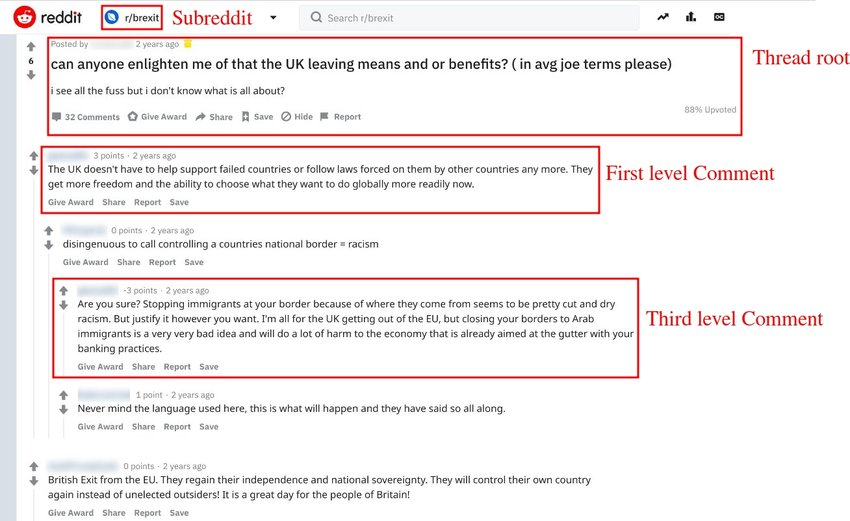 The first comment (context) is always followed by the second comment (target), which should be the comment, that the machine learning model classifies into Hate, Neutral and Counter Hate. The dataset comes with labels and thus this is supervised learning. Anyway let's start analysing the dataset. 


The dataset is divided into 2 folders silver and gold:

1.   Gold Folder (4,751 entries):

*   train.json (3325 entries)
*   val.json (713 entries) 
*   test.json (713 entries)

2.   Silver Folder (2.094 entries):

*   train.json (1675 entries)
*   val.json (419 entries) 


Let's start by looking in detail at the gold folder of the dataset. Notice that I commented out 3 datasets, which are a combination of both the gold and silver data. I did this due to time concerns and not really proper documentation on my part and will focus on the gold dataset entierly going forward. I also included the path to the pre processed dataset for analysis, which was of course pre processed based on the result and insights I obtained by analysing the gold dataset. We start by converting our dataset to pandas dataframes.


In [ ]:
gold='/content/drive/MyDrive/BSP6/init_dataset_gold'
gold_pre_processed = '/content/drive/MyDrive/BSP6/init_dataset_gold_preprocessed' 
gold_oversampled ='/content/drive/MyDrive/BSP6/init_dataset_gold_silver_balance'
gold_undersampled ='/content/drive/MyDrive/BSP6/init_dataset_gold_balance'
gold_oversample_pre='/content/drive/MyDrive/BSP6/init_dataset_gold_preprocessed_oversample'


#silver='/content/drive/MyDrive/BSP6/init_dataset_silver' #intial silver dataset
#gold_silver='/content/drive/MyDrive/BSP6/init_dataset_gold_silver' #gold and silver merged for train and val | gold for test
#gold_silver_train_gold_val='/content/drive/MyDrive/BSP6/init_dataset_gold_silver_train_gold_val' #gold and silver merged for train |  gold for val and test

os.chdir(gold) 
dirs = os.listdir(gold)
for file in dirs:
   print(file)

train_data = pd.read_json('train.json', lines=True)
val_data = pd.read_json('val.json', lines=True)
test_data = pd.read_json('test.json', lines=True)


test.json
train.json
val.json
Report
results


First we want to see how the data is distributed over Training, Validation and Testing Set, which is represented by the different JSON Files.
Remember that the purpose of these splits are:

    
    
    

1.   Training set: This data is used to train the model parameters.
2.   Validation set: This data is used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. It is also used for regularization methods like pruning, early stopping, or model selection.
3. Test set: This data is used to provide an unbiased evaluation of a final model fit on the training dataset. It is only used once a model is completely trained.

In the field of machine learning, and especially in natural language processing (NLP), the commonly adopted practice for splitting a dataset is the 70-15-15 or 80-10-10 rule




train.json: 3325
val.json: 713
test.json: 713
all entries in the dataset: 4751


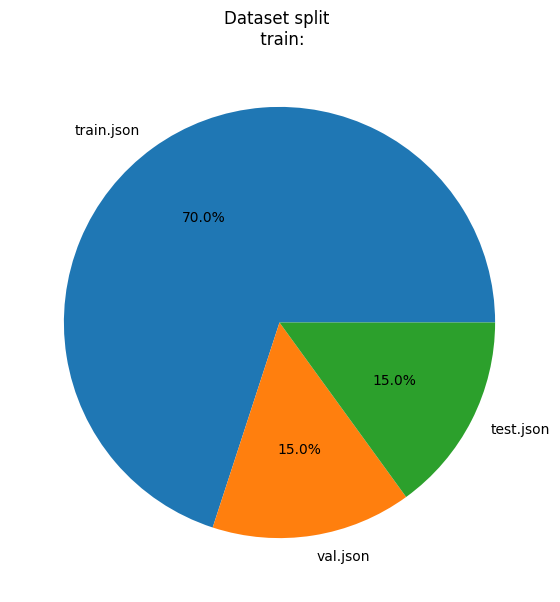

In [ ]:
l_train=len(train_data)
l_val=len(val_data)
l_test=len(test_data)
show_dataset_pie(l_train,l_val,l_test)

The given split in the dataset seems pretty reasonable and follows the standard practice for dataset splits in machine learning.

Now I want to see how an overview over the different sets. 

Look at example representative entries of the dataset


,idx,label,context,target
0,0,2,The UK is fucked.,>The ~~UK~~ world is fucked FTFY
1,1,0,Listen to this wisdom.,Where the Fuck did you get that up arrow?



Dataset complete
No Duplicates
How many values are in each column of the dataset?


idx        3325
label      3325
context    3325
target     3325
dtype: int64


How balanced is the dataset?


1    0.489323
0    0.277293
2    0.233383
Name: label, dtype: float64


Look at example representative entries of the dataset


,idx,label,context,target
0,0,2,The UK is fucked.,>The ~~UK~~ world is fucked FTFY
1,1,0,Listen to this wisdom.,Where the Fuck did you get that up arrow?


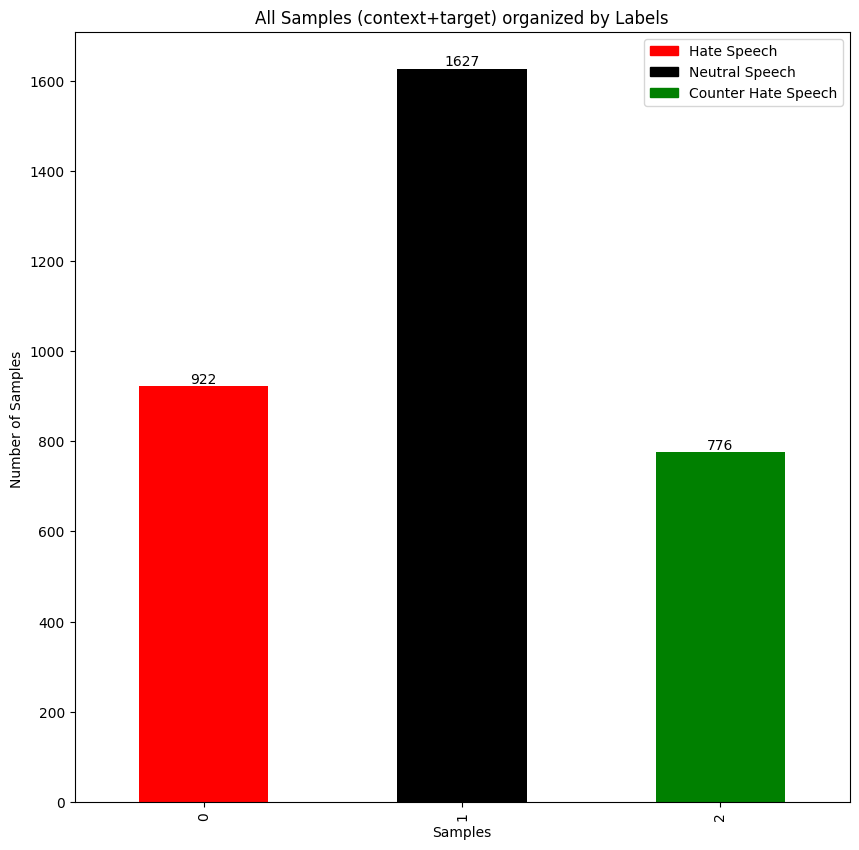

In [ ]:
# 0 = Hate
# 1 = Neutral
# 2 = Counter Hate

overview_data(train_data)
visualize_overview_dataset(train_data)

Look at example representative entries of the dataset


,idx,label,context,target
0,0,2,The fact that you think that is sufficient for...,Not being able to find a job for 20 years soun...
1,1,2,Because it's not true you fucking liar. Not ev...,Can't handle the truth hmmmm?



Dataset complete
No Duplicates
How many values are in each column of the dataset?


idx        713
label      713
context    713
target     713
dtype: int64


How balanced is the dataset?


1    0.499299
0    0.283310
2    0.217391
Name: label, dtype: float64


Look at example representative entries of the dataset


,idx,label,context,target
0,0,2,The fact that you think that is sufficient for...,Not being able to find a job for 20 years soun...
1,1,2,Because it's not true you fucking liar. Not ev...,Can't handle the truth hmmmm?


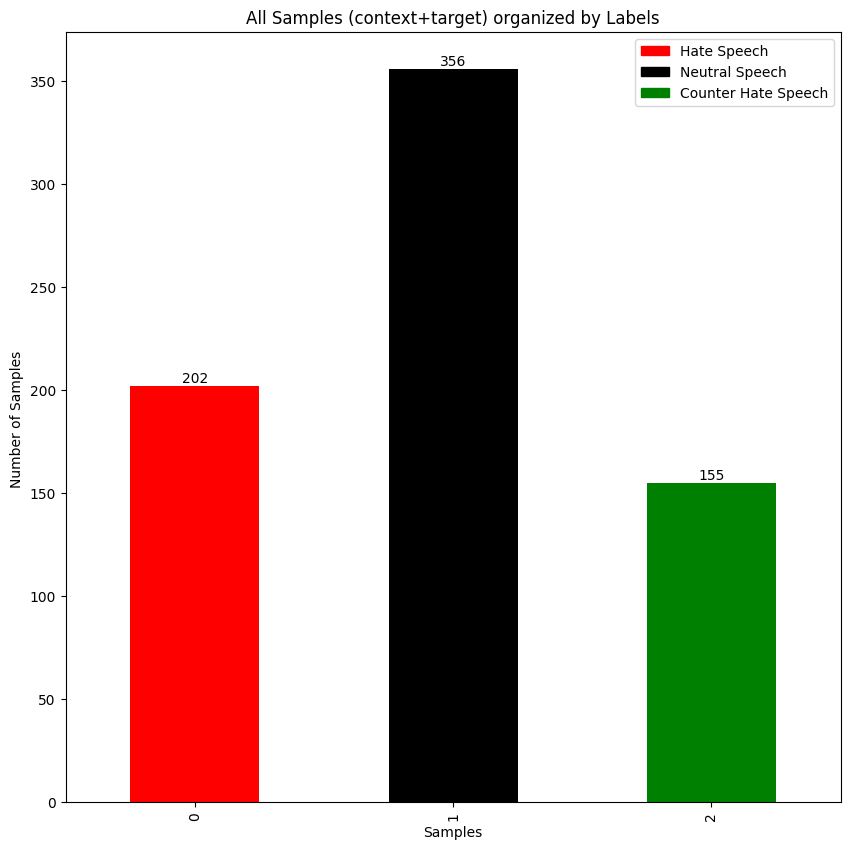

In [ ]:
overview_data(val_data)
visualize_overview_dataset(val_data)

Look at example representative entries of the dataset


,idx,label,context,target
0,0,2,Someone on Tumblr actually complied a list and...,Can I get a link to that?
1,1,1,"She has no trouble using Feminism to help her,...",Rand Paul thinks so too. Maybe you should vote...



Dataset complete
No Duplicates
How many values are in each column of the dataset?


idx        713
label      713
context    713
target     713
dtype: int64


How balanced is the dataset?


1    0.506311
0    0.258065
2    0.235624
Name: label, dtype: float64


Look at example representative entries of the dataset


,idx,label,context,target
0,0,2,Someone on Tumblr actually complied a list and...,Can I get a link to that?
1,1,1,"She has no trouble using Feminism to help her,...",Rand Paul thinks so too. Maybe you should vote...


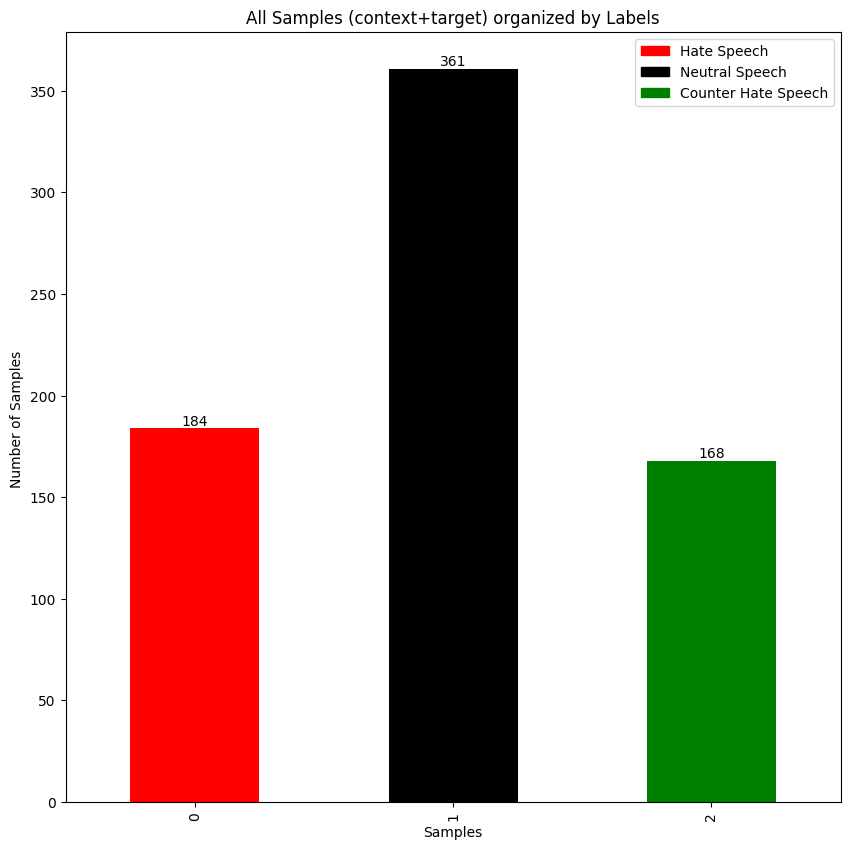

In [ ]:
overview_data(test_data)
visualize_overview_dataset(test_data)

The distributions indicate that the three subsets of the data (training, validation, and testing) are not perfectly balanced in terms of their label distribution, but they are close.
It's important to note that machine learning models trained on imbalanced datasets can be biased towards the majority class, in this case, neutral comments. They might perform poorly on the minority class.
However, the dataset is only slightly imbalanced. Given this slight imbalance, it might not heavily impact model performance, especially if you use metrics like precision, recall, or F1-score, which can handle imbalance better than accuracy.

If the imbalance causes issues, it might be worth to consider techniques like oversampling the minority class, undersampling the majority class, or using synthetic data augmentation techniques such as SMOTE  (Synthetic Minority Over-sampling Technique) .

In summary, while there is a slight imbalance in your datasets, it's good that the class distributions are similar across the training, validation, and test sets. This similarity ensures that the model's performance on the validation and test sets will be a good indicator of its performance on new, unseen data.

Now want to see how long the context and target sentences of the different sets are in terms of charcter length: 

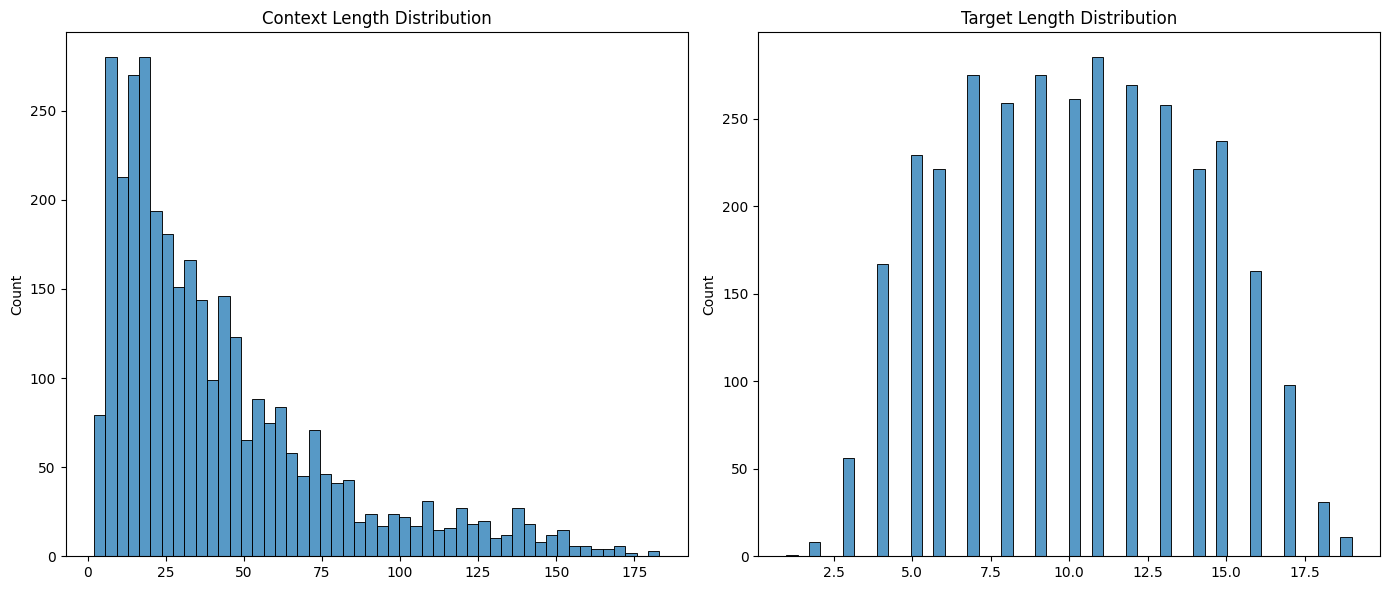

In [ ]:
# Create a new column for context length and target length
train_data['context_length'] = train_data['context'].apply(lambda x: len(x.split()))
train_data['target_length'] = train_data['target'].apply(lambda x: len(x.split()))

# Plot length distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.histplot(train_data['context_length'].values, bins=50, kde=False)
plt.title('Context Length Distribution')

plt.subplot(1,2,2)
sns.histplot(train_data['target_length'].values, bins=50, kde=False)
plt.title('Target Length Distribution')

plt.tight_layout()
plt.show()

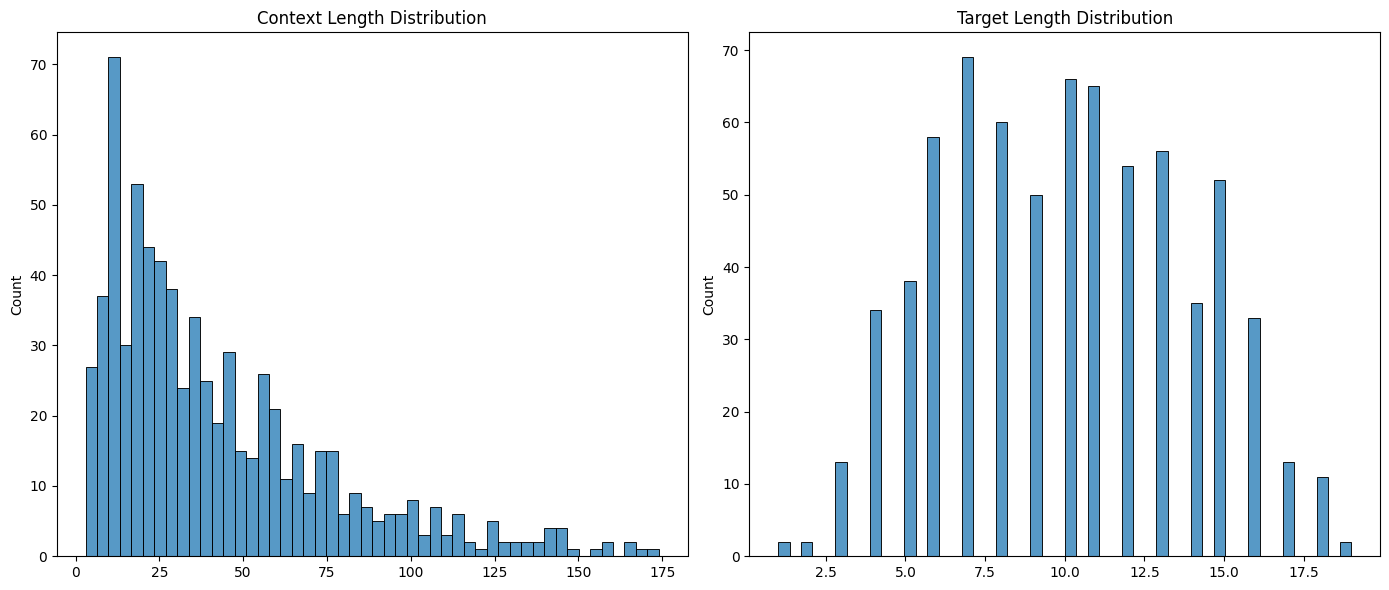

In [ ]:
# Create a new column for context length and target length
val_data['context_length'] = val_data['context'].apply(lambda x: len(x.split()))
val_data['target_length'] = val_data['target'].apply(lambda x: len(x.split()))

# Plot length distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.histplot(val_data['context_length'].values, bins=50, kde=False)
plt.title('Context Length Distribution')

plt.subplot(1,2,2)
sns.histplot(val_data['target_length'].values, bins=50, kde=False)
plt.title('Target Length Distribution')

plt.tight_layout()
plt.show()

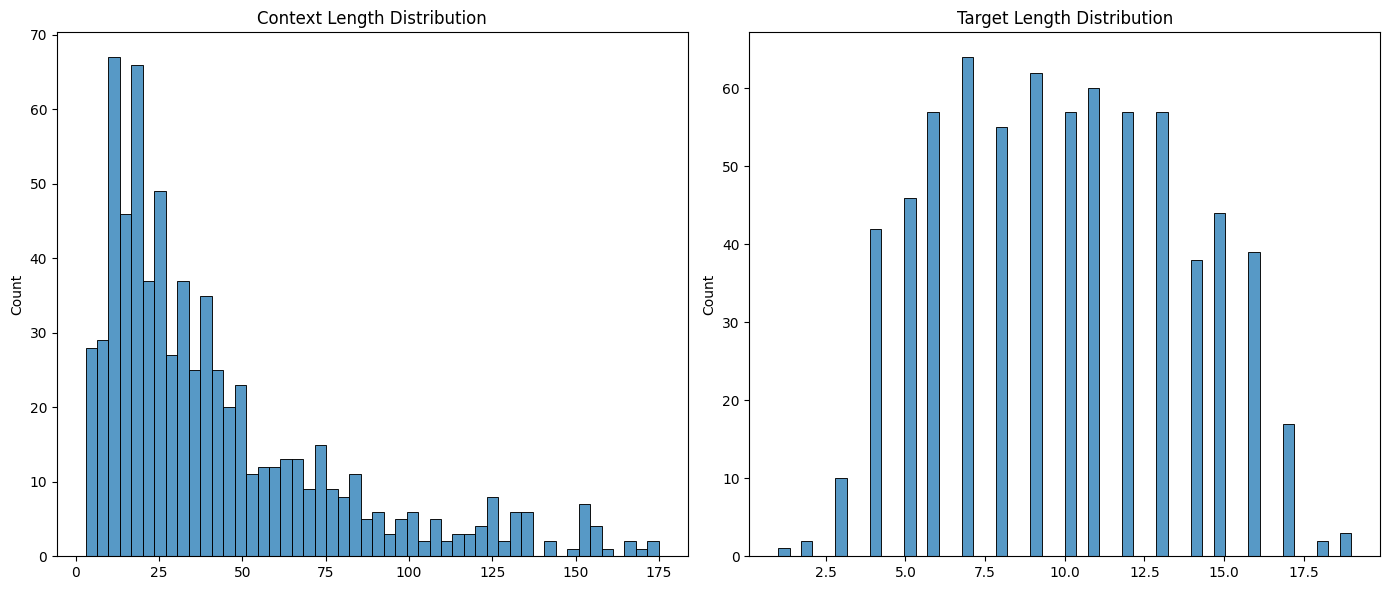

In [ ]:
# Create a new column for context length and target length
test_data['context_length'] = test_data['context'].apply(lambda x: len(x.split()))
test_data['target_length'] = test_data['target'].apply(lambda x: len(x.split()))

# Plot length distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.histplot(test_data['context_length'].values, bins=50, kde=False)
plt.title('Context Length Distribution')

plt.subplot(1,2,2)
sns.histplot(test_data['target_length'].values, bins=50, kde=False)
plt.title('Target Length Distribution')

plt.tight_layout()
plt.show()

As you can see train,val and test set are again overall very similiar in terms of the character lenght destribution when it comes to context and target sentences, which is a good thing. You should notice that there is a huge difference in terms of charcter length of the context (about 10-175) and target sentences (2-18). In the context you have a more dense distribution on the lower part (0 to 50 characters) while in the target is more evenly distributed.

Now we apply sentiment analysis,Sentiment scores can serve as additional features for the machine learning model. For instance, extremely negative sentiments may be indicative of hate speech. But sentiment analysis is a broad technique and may not capture the specifics of hate speech perfectly. 

In [ ]:
# Apply function to context and target
train_data['context_polarity'] = train_data['context'].apply(get_polarity)
train_data['target_polarity'] = train_data['target'].apply(get_polarity)
val_data['context_polarity'] = train_data['context'].apply(get_polarity)
val_data['target_polarity'] = train_data['target'].apply(get_polarity)
test_data['context_polarity'] = train_data['context'].apply(get_polarity)
test_data['target_polarity'] = train_data['target'].apply(get_polarity)

Now calculate a heatmap corrilation matrix to see if the previous added feature like sentiment analysis have a strong influence on the label. 

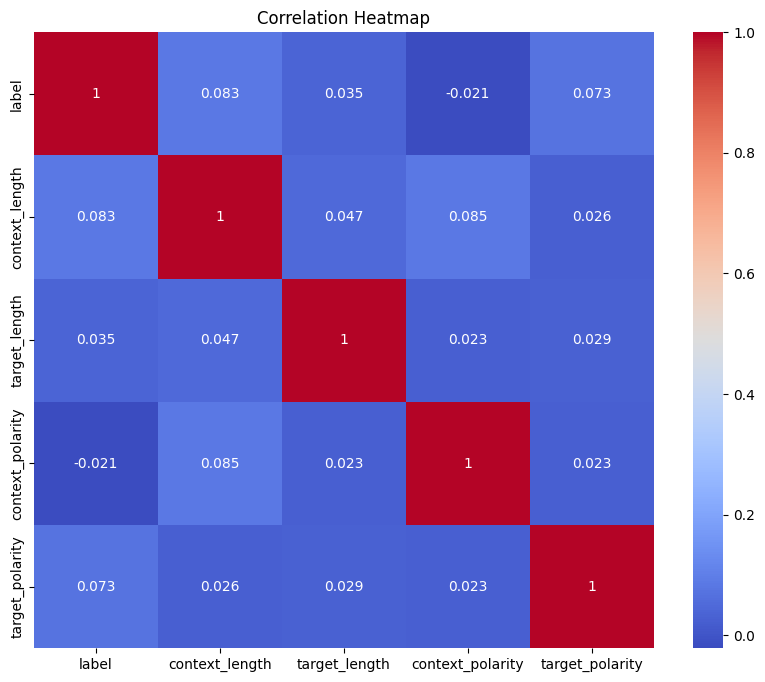

In [ ]:
correlation_df = train_data[['label', 'context_length', 'target_length', 'context_polarity','target_polarity']]

# Calculate the correlation matrix
corr = correlation_df.corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.title('Correlation Heatmap')
plt.show()

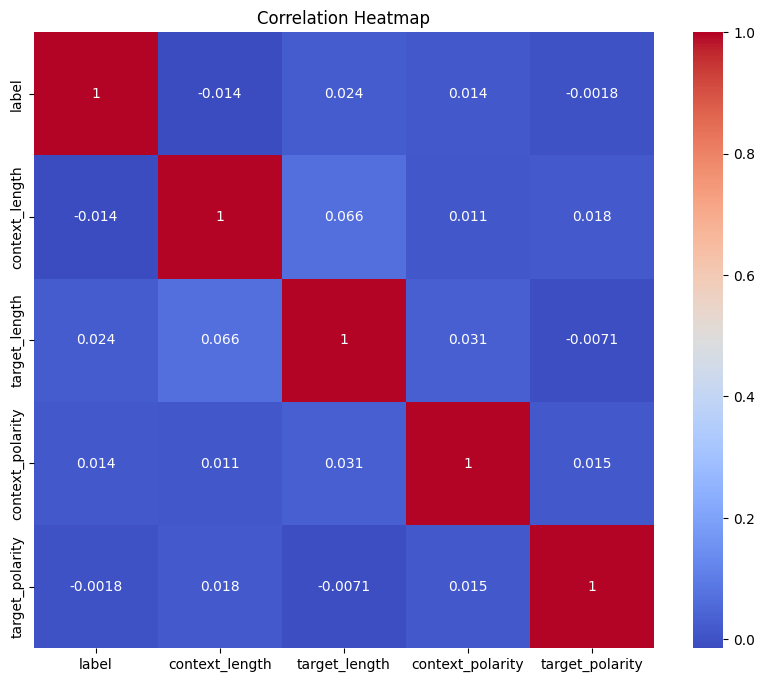

In [ ]:
correlation_df = val_data[['label', 'context_length', 'target_length', 'context_polarity','target_polarity']]

# Calculate the correlation matrix
corr = correlation_df.corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.title('Correlation Heatmap')
plt.show()

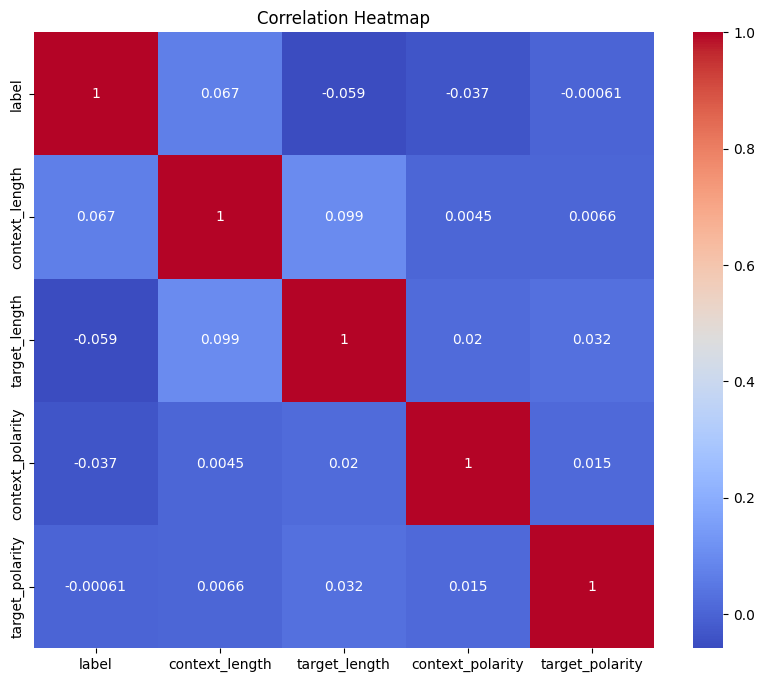

In [ ]:
correlation_df = test_data[['label', 'context_length', 'target_length', 'context_polarity','target_polarity']]

# Calculate the correlation matrix
corr = correlation_df.corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.title('Correlation Heatmap')
plt.show()

Positive values indicate a positive correlation (as one variable increases, so does the other), negative values indicate a negative correlation (as one variable increases, the other decreases), and values close to 0 indicate little to no correlation.As you can see all the values apart from the diagonal are very close to 0, so there is no corralation between the sentiment and the label of a comment pair.

#Traing Set

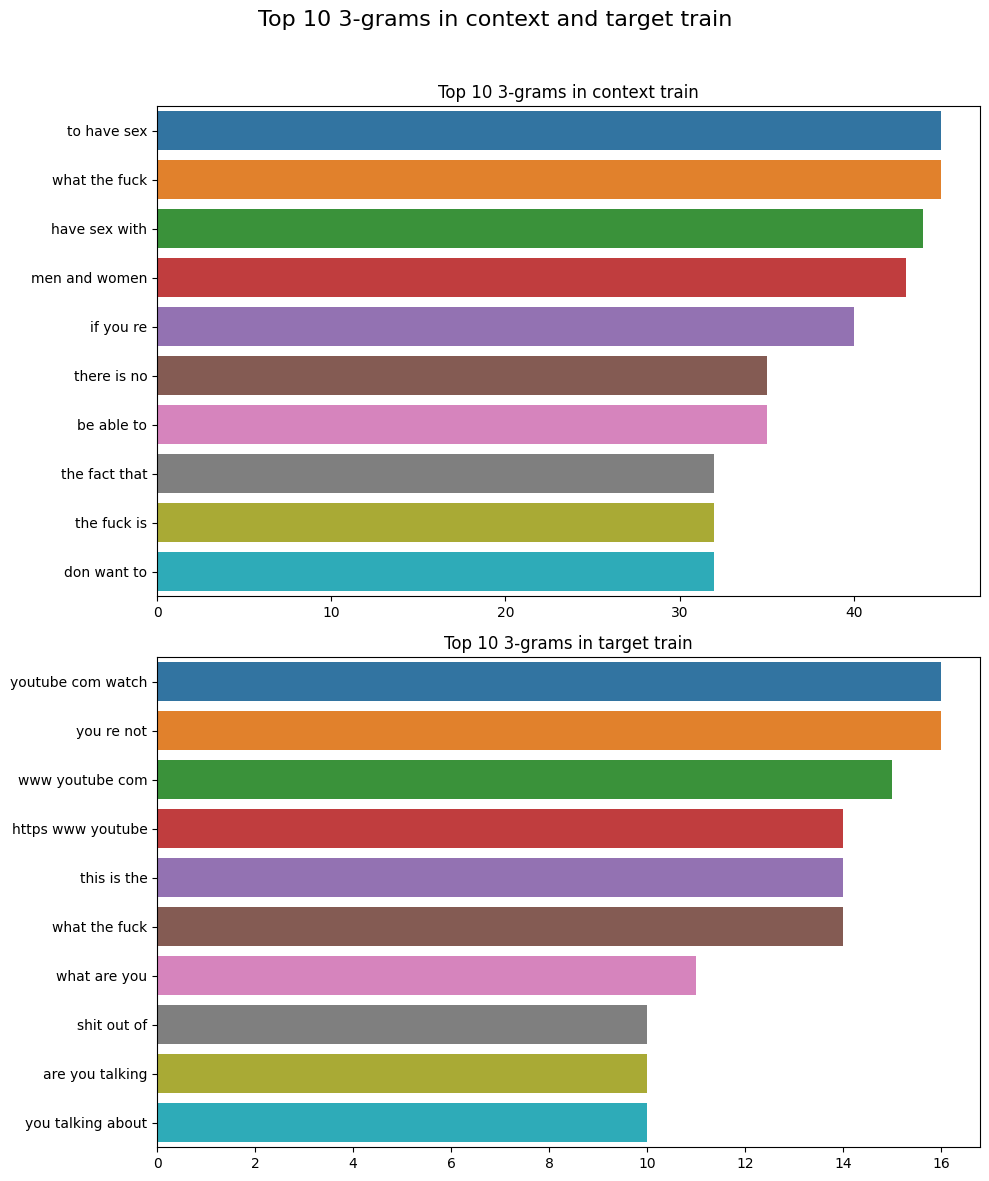

In [ ]:
# Compute the top 10 5-grams for context and target
top_n_bigrams_context = get_top_ngrams(train_data['context'], 10, 3)
top_n_bigrams_target = get_top_ngrams(train_data['target'], 10, 3)

# Prepare for subplotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot context 5-grams
x_context, y_context = map(list, zip(*top_n_bigrams_context))
sns.barplot(x=y_context, y=x_context, ax=ax[0])
ax[0].set_title("Top 10 3-grams in context train")

# Plot target 5-grams
x_target, y_target = map(list, zip(*top_n_bigrams_target))
sns.barplot(x=y_target, y=x_target, ax=ax[1])
ax[1].set_title("Top 10 3-grams in target train")

# Add a main title for the entire plot
plt.suptitle("Top 10 3-grams in context and target train", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # This will make sure your main title doesn't overlap with subplots
plt.show()

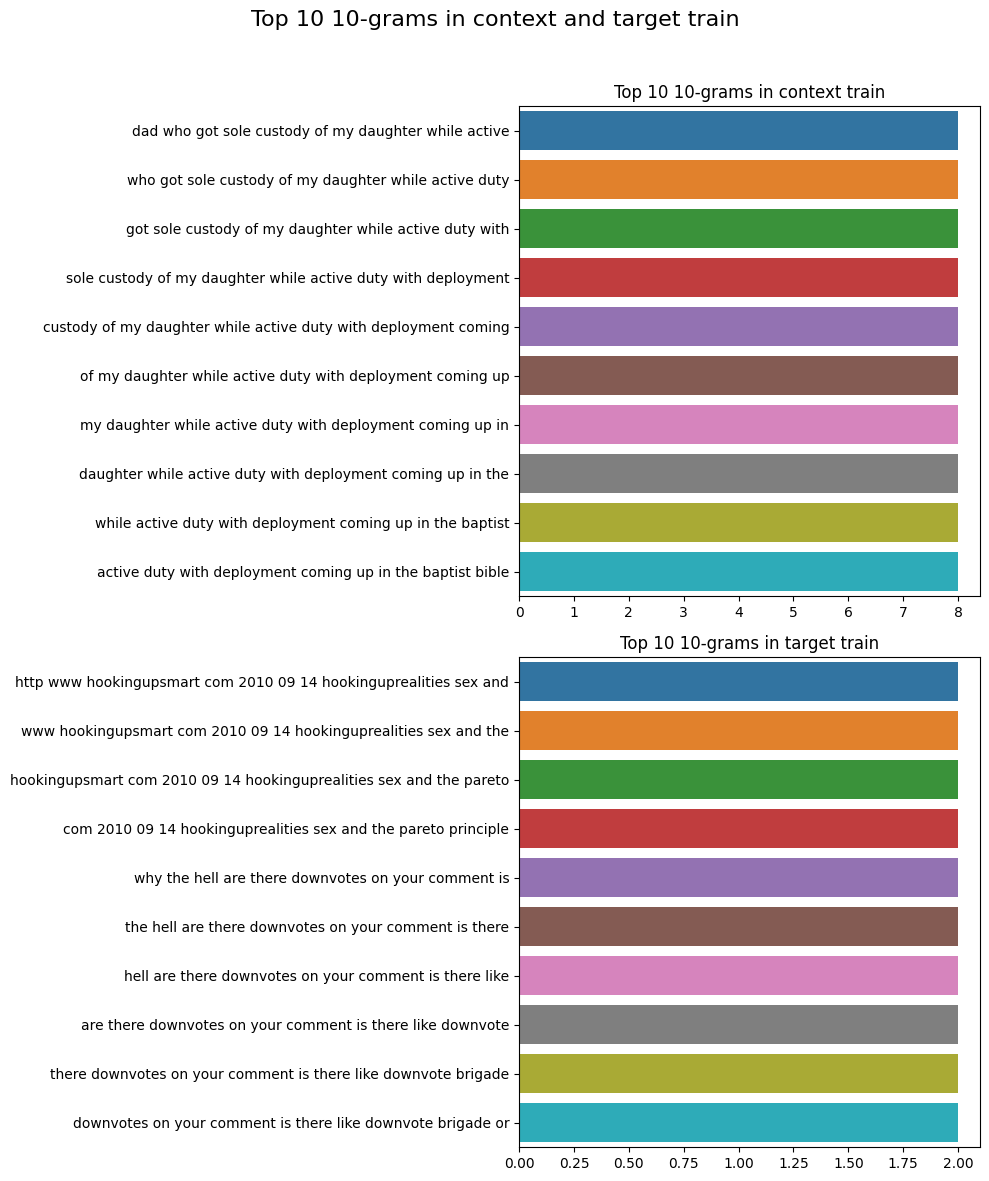

In [ ]:
# Compute the top 10 5-grams for context and target
top_n_bigrams_context = get_top_ngrams(train_data['context'], 10, 10)
top_n_bigrams_target = get_top_ngrams(train_data['target'], 10, 10)

# Prepare for subplotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot context 5-grams
x_context, y_context = map(list, zip(*top_n_bigrams_context))
sns.barplot(x=y_context, y=x_context, ax=ax[0])
ax[0].set_title("Top 10 10-grams in context train")

# Plot target 5-grams
x_target, y_target = map(list, zip(*top_n_bigrams_target))
sns.barplot(x=y_target, y=x_target, ax=ax[1])
ax[1].set_title("Top 10 10-grams in target train")

# Add a main title for the entire plot
plt.suptitle("Top 10 10-grams in context and target train", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # This will make sure your main title doesn't overlap with subplots
plt.show()

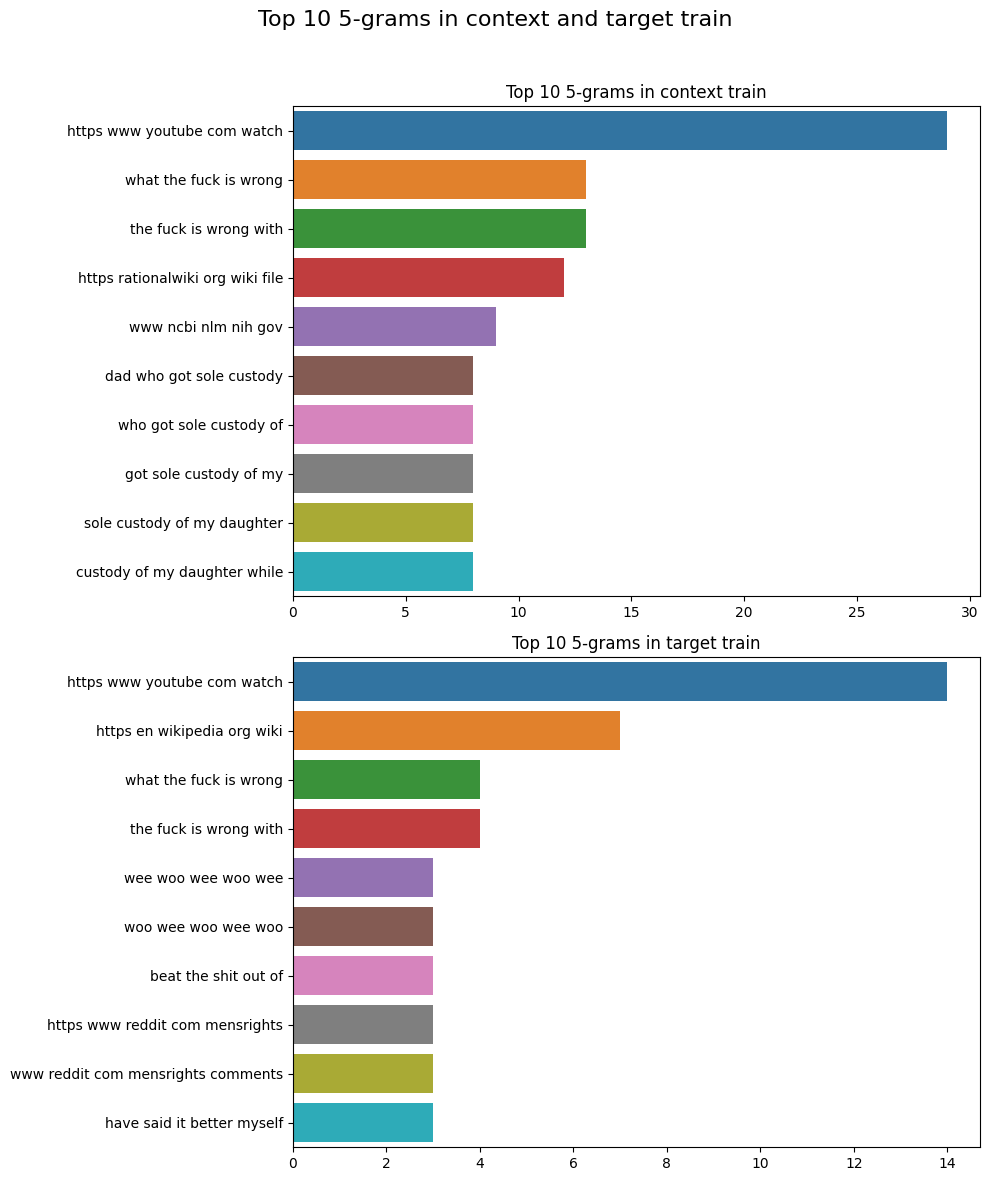

In [ ]:
# Compute the top 10 5-grams for context and target
top_n_bigrams_context = get_top_ngrams(train_data['context'], 10, 5)
top_n_bigrams_target = get_top_ngrams(train_data['target'], 10, 5)

# Prepare for subplotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot context 5-grams
x_context, y_context = map(list, zip(*top_n_bigrams_context))
sns.barplot(x=y_context, y=x_context, ax=ax[0])
ax[0].set_title("Top 10 5-grams in context train")

# Plot target 5-grams
x_target, y_target = map(list, zip(*top_n_bigrams_target))
sns.barplot(x=y_target, y=x_target, ax=ax[1])
ax[1].set_title("Top 10 5-grams in target train")

# Add a main title for the entire plot
plt.suptitle("Top 10 5-grams in context and target train", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # This will make sure your main title doesn't overlap with subplots
plt.show()

#Validation Set

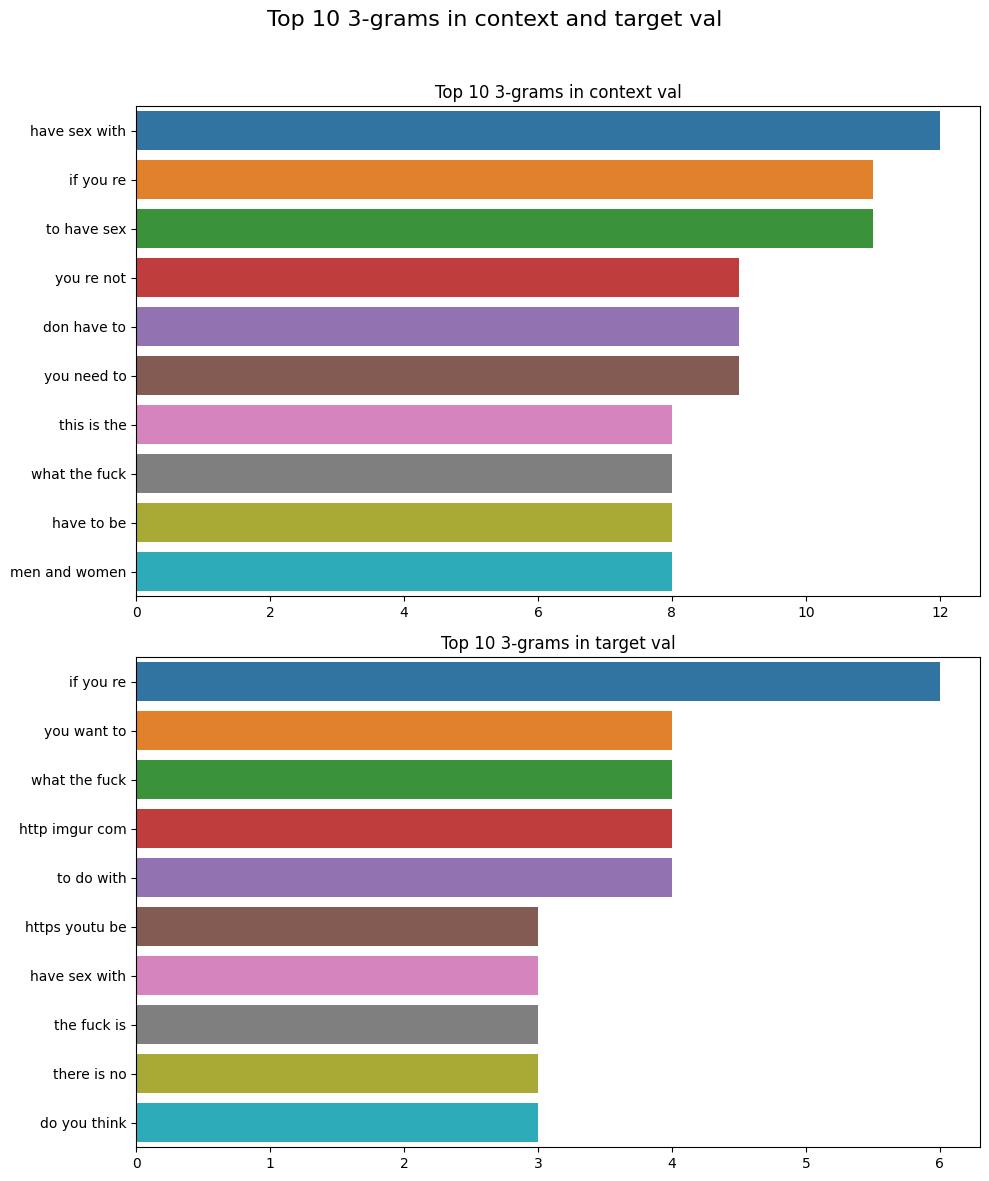

In [ ]:
# Compute the top 10 5-grams for context and target
top_n_bigrams_context = get_top_ngrams(val_data['context'], 10, 3)
top_n_bigrams_target = get_top_ngrams(val_data['target'], 10, 3)

# Prepare for subplotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot context 5-grams
x_context, y_context = map(list, zip(*top_n_bigrams_context))
sns.barplot(x=y_context, y=x_context, ax=ax[0])
ax[0].set_title("Top 10 3-grams in context val")

# Plot target 5-grams
x_target, y_target = map(list, zip(*top_n_bigrams_target))
sns.barplot(x=y_target, y=x_target, ax=ax[1])
ax[1].set_title("Top 10 3-grams in target val")

# Add a main title for the entire plot
plt.suptitle("Top 10 3-grams in context and target val", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # This will make sure your main title doesn't overlap with subplots
plt.show()

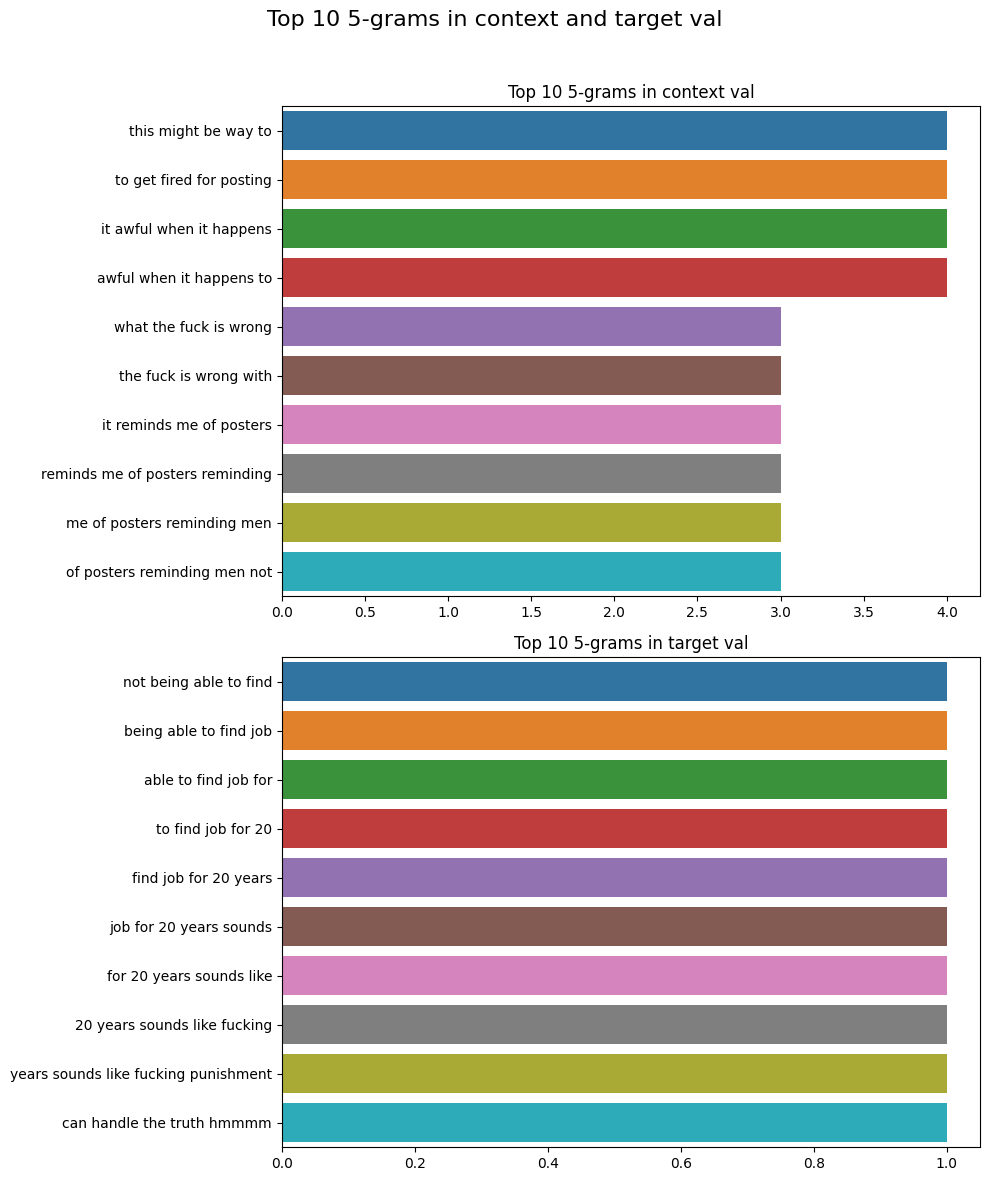

In [ ]:
# Compute the top 10 5-grams for context and target
top_n_bigrams_context = get_top_ngrams(val_data['context'], 10, 5)
top_n_bigrams_target = get_top_ngrams(val_data['target'], 10, 5)

# Prepare for subplotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot context 5-grams
x_context, y_context = map(list, zip(*top_n_bigrams_context))
sns.barplot(x=y_context, y=x_context, ax=ax[0])
ax[0].set_title("Top 10 5-grams in context val")

# Plot target 5-grams
x_target, y_target = map(list, zip(*top_n_bigrams_target))
sns.barplot(x=y_target, y=x_target, ax=ax[1])
ax[1].set_title("Top 10 5-grams in target val")

# Add a main title for the entire plot
plt.suptitle("Top 10 5-grams in context and target val", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # This will make sure your main title doesn't overlap with subplots
plt.show()

Testing Set

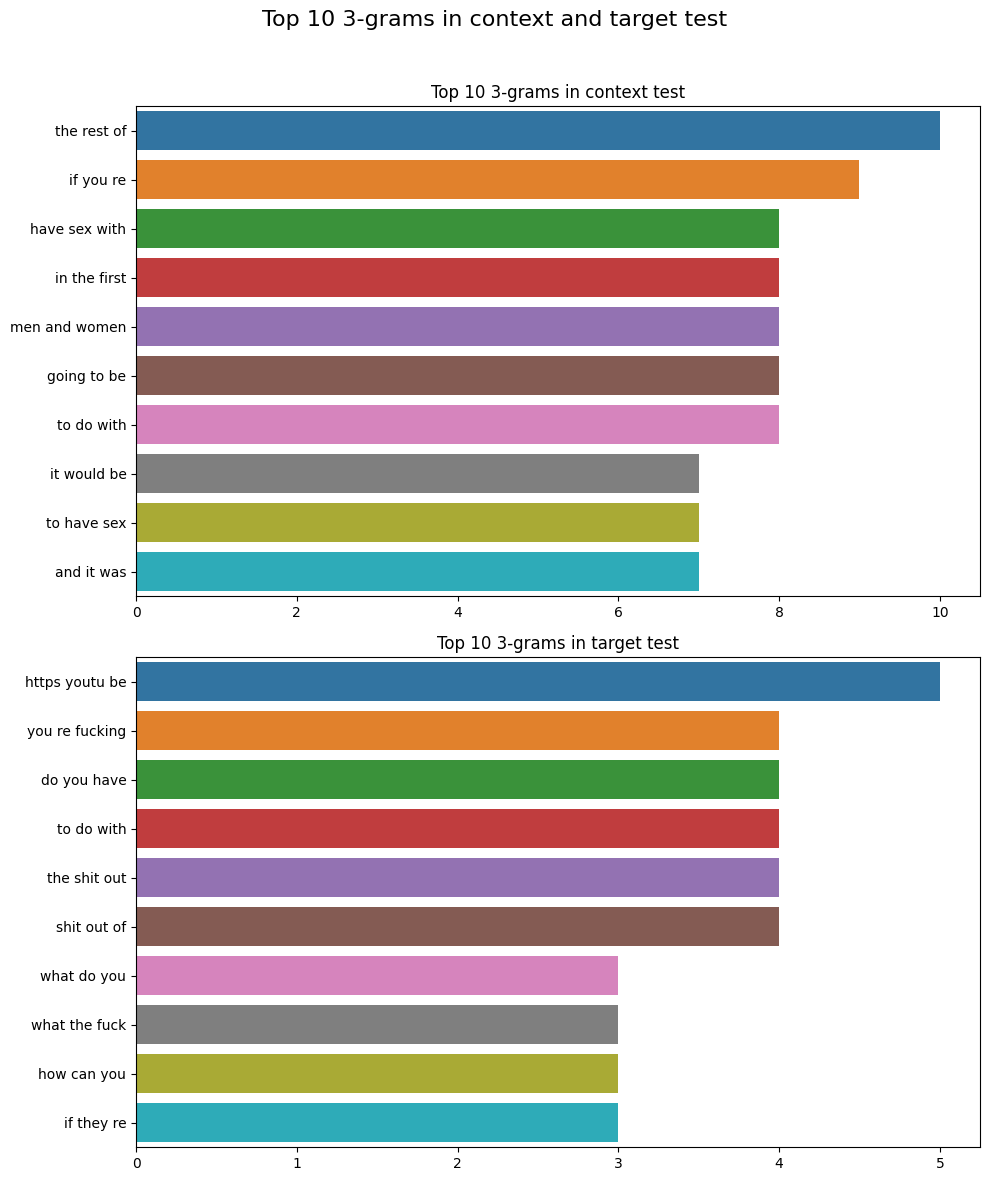

In [ ]:
# Compute the top 10 5-grams for context and target
top_n_bigrams_context = get_top_ngrams(test_data['context'], 10, 3)
top_n_bigrams_target = get_top_ngrams(test_data['target'], 10, 3)

# Prepare for subplotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot context 5-grams
x_context, y_context = map(list, zip(*top_n_bigrams_context))
sns.barplot(x=y_context, y=x_context, ax=ax[0])
ax[0].set_title("Top 10 3-grams in context test")

# Plot target 5-grams
x_target, y_target = map(list, zip(*top_n_bigrams_target))
sns.barplot(x=y_target, y=x_target, ax=ax[1])
ax[1].set_title("Top 10 3-grams in target test")

# Add a main title for the entire plot
plt.suptitle("Top 10 3-grams in context and target test", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # This will make sure your main title doesn't overlap with subplots
plt.show()

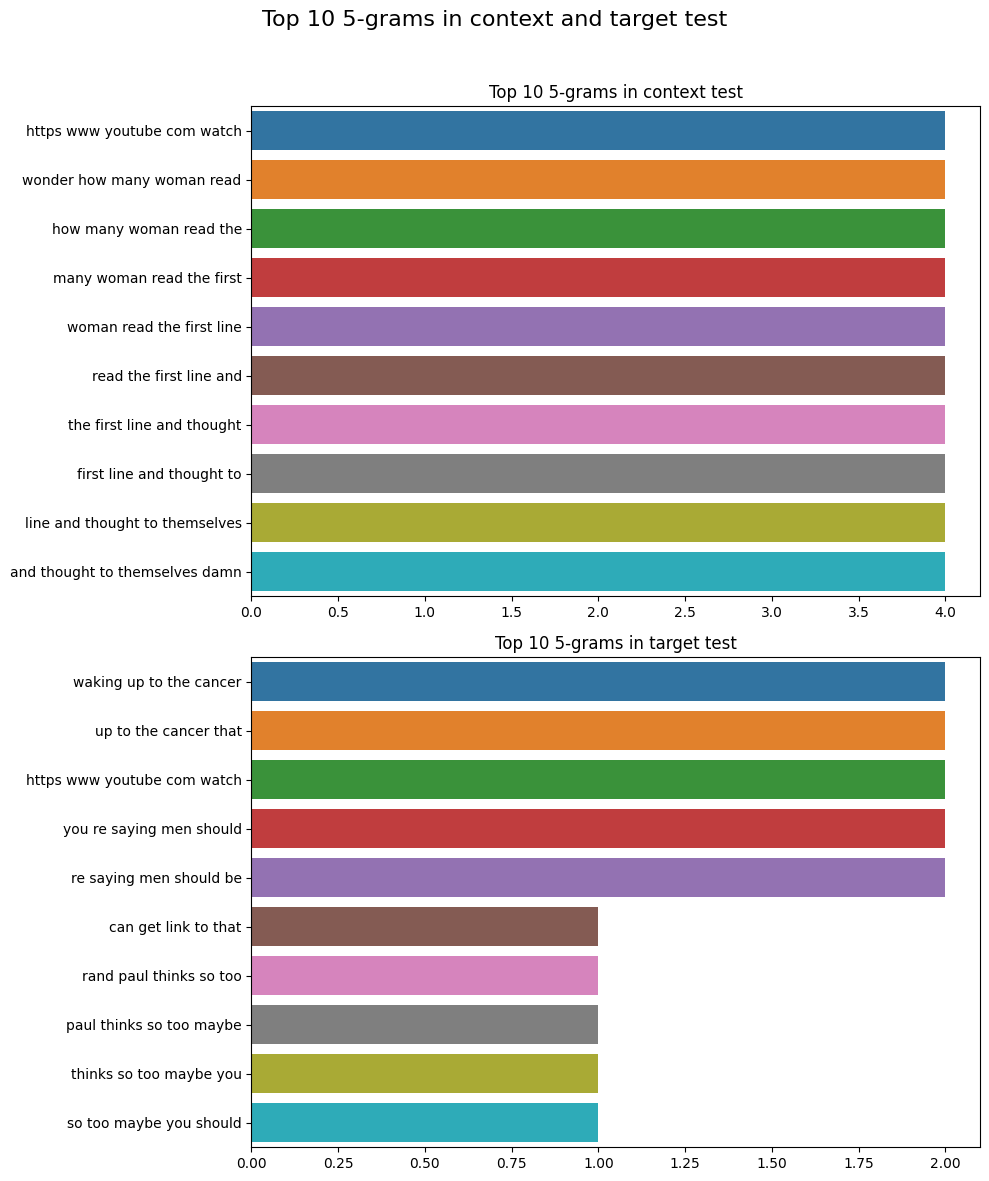

In [ ]:
# Compute the top 10 5-grams for context and target
top_n_bigrams_context = get_top_ngrams(test_data['context'], 10, 5)
top_n_bigrams_target = get_top_ngrams(test_data['target'], 10, 5)

# Prepare for subplotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot context 5-grams
x_context, y_context = map(list, zip(*top_n_bigrams_context))
sns.barplot(x=y_context, y=x_context, ax=ax[0])
ax[0].set_title("Top 10 5-grams in context test")

# Plot target 5-grams
x_target, y_target = map(list, zip(*top_n_bigrams_target))
sns.barplot(x=y_target, y=x_target, ax=ax[1])
ax[1].set_title("Top 10 5-grams in target test")

# Add a main title for the entire plot
plt.suptitle("Top 10 5-grams in context and target test", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # This will make sure your main title doesn't overlap with subplots
plt.show()

Oha! This is very interetsing observation. Note that for the context in the test set as well for context and for training in the train set, there are some url that come up as 5 grams like youtube or wikipedia. These are not informative in terms of Hate or no Hate or Couner , since they most likely do not contain words but ID in the url.So we should remove them in the pre processing.

Now we take a look at word clouds. They serve as a valuable exploratory tool in dataset analysis, providing a quick overview and facilitating the identification of significant words, topics, and patterns. 

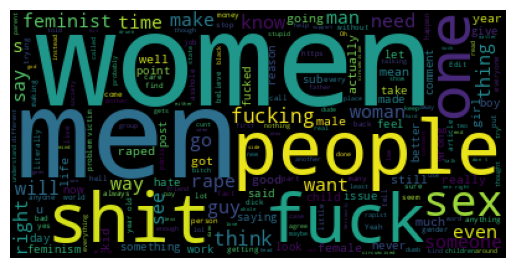

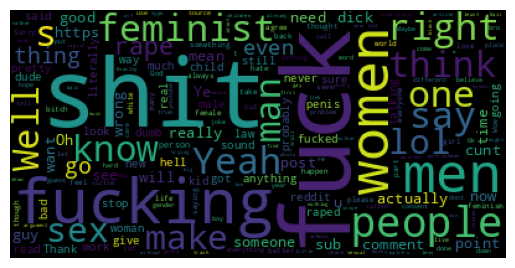

In [ ]:
wordcloud_context(train_data)
wordcloud_target(train_data)

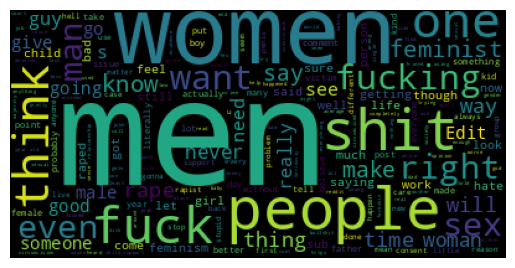

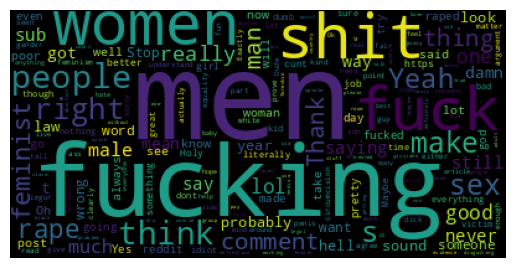

In [ ]:
wordcloud_context(val_data)
wordcloud_target(val_data)

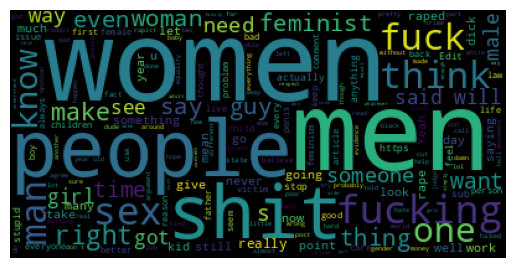

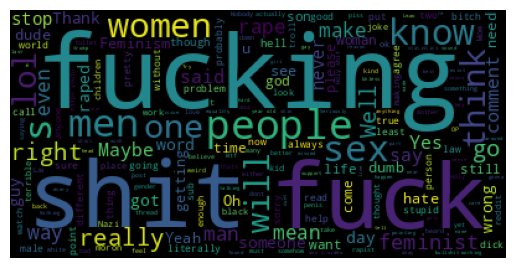

In [ ]:
wordcloud_context(test_data)
wordcloud_target(test_data)

Kind of the same for all different sets, which is good. Now we know that the topic often is related to the terms: fucking, shit, fuck, men and women.

Now we have a look at the tokenization and specifically the lenght, which is important for the tokenizer, when doing the model training. 

In [ ]:
overview_tokenization(train_data)

Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors


count    3325.000000
mean       57.285714
std        47.478194
min         7.000000
25%        24.000000
50%        42.000000
75%        75.000000
80%        86.000000
95%       162.000000
99%       204.000000
max       609.000000
Name: length_of_token_ids_c, dtype: float64

count    3325.000000
mean       16.067669
std         7.372008
min         5.000000
25%        11.000000
50%        16.000000
75%        19.000000
80%        20.000000
95%        24.000000
99%        41.760000
max       187.000000
Name: length_of_token_ids_t, dtype: float64

count    3325.000000
mean       71.182556
std        48.327510
min        14.000000
25%        37.000000
50%        56.000000
75%        90.000000
80%       101.200000
95%       177.800000
99%       220.760000
max       619.000000
Name: length_of_token_ids_ct, dtype: float64


Sequence length is longer than the specified maximum sequence length (512) 


,idx,label,context,target,context_length,target_length,context_polarity,target_polarity,tokens_c,token_ids_c,length_of_token_ids_c,tokens_t,token_ids_t,length_of_token_ids_t,tokens_ct,token_ids_ct,length_of_token_ids_ct
932,932,1,^^Note: ^^The ^^vast ^^majority ^^of ^^these ^...,"Yeah, this aint gonna fit in a tweet...",139,8,0.269231,0.4,"[^^, Note, :, Ġ^, ^, The, Ġ^, ^, v, ast, Ġ^, ^...","[0, 48232, 27728, 35, 37249, 35227, 133, 37249...",609,"[Yeah, ,, Ġthis, Ġa, int, Ġgonna, Ġfit, Ġin, Ġ...","[0, 14783, 6, 42, 10, 2544, 6908, 2564, 11, 10...",13,"[^^, Note, :, Ġ^, ^, The, Ġ^, ^, v, ast, Ġ^, ^...","[0, 48232, 27728, 35, 37249, 35227, 133, 37249...",619


In [ ]:
overview_tokenization(val_data)

count    713.000000
mean      57.274895
std       43.615920
min        7.000000
25%       25.000000
50%       44.000000
75%       79.000000
80%       90.000000
95%      149.000000
99%      193.880000
max      237.000000
Name: length_of_token_ids_c, dtype: float64

count    713.000000
mean      15.858345
std        6.285874
min        6.000000
25%       12.000000
50%       15.000000
75%       19.000000
80%       20.000000
95%       23.000000
99%       38.880000
max       74.000000
Name: length_of_token_ids_t, dtype: float64

count    713.000000
mean      70.957924
std       44.623625
min       15.000000
25%       37.000000
50%       57.000000
75%       93.000000
80%      104.000000
95%      164.000000
99%      211.880000
max      259.000000
Name: length_of_token_ids_ct, dtype: float64

In [ ]:
overview_tokenization(test_data)

count    713.000000
mean      58.200561
std       47.647941
min        7.000000
25%       24.000000
50%       42.000000
75%       76.000000
80%       89.600000
95%      172.400000
99%      204.880000
max      257.000000
Name: length_of_token_ids_c, dtype: float64

count    713.000000
mean      15.291725
std        5.276528
min        6.000000
25%       11.000000
50%       15.000000
75%       19.000000
80%       20.000000
95%       23.000000
99%       29.880000
max       53.000000
Name: length_of_token_ids_t, dtype: float64

count    713.000000
mean      71.346424
std       48.645638
min       13.000000
25%       36.000000
50%       55.000000
75%       91.000000
80%      103.000000
95%      184.400000
99%      220.760000
max      266.000000
Name: length_of_token_ids_ct, dtype: float64

Now we know that the sentence target tokens are significantly shorter than sentence context tokens. And a to cover 99% of all tokens it is enought to use a max token length of 225 instead of BERT initial 513. This can save traing time and memory on the GPU.   

In [ ]:
val_data

,idx,label,context,target,context_length,target_length,context_polarity,target_polarity,tokens_c,token_ids_c,length_of_token_ids_c,tokens_t,token_ids_t,length_of_token_ids_t,tokens_ct,token_ids_ct,length_of_token_ids_ct
0,0,2,The fact that you think that is sufficient for...,Not being able to find a job for 20 years soun...,81,15,-0.600000,-0.600000,"[The, Ġfact, Ġthat, Ġyou, Ġthink, Ġthat, Ġis, ...","[0, 133, 754, 14, 47, 206, 14, 16, 7719, 13, 2...",118,"[Not, Ġbeing, Ġable, Ġto, Ġfind, Ġa, Ġjob, Ġfo...","[0, 7199, 145, 441, 7, 465, 10, 633, 13, 291, ...",18,"[The, Ġfact, Ġthat, Ġyou, Ġthink, Ġthat, Ġis, ...","[0, 133, 754, 14, 47, 206, 14, 16, 7719, 13, 2...",134
1,1,2,Because it's not true you fucking liar. Not ev...,Can't handle the truth hmmmm?,11,5,0.000000,-0.400000,"[Because, Ġit, 's, Ġnot, Ġtrue, Ġyou, Ġfucking...","[0, 10105, 24, 18, 45, 1528, 47, 23523, 28587,...",16,"[Can, 't, Ġhandle, Ġthe, Ġtruth, Ġh, mmmm, ?]","[0, 10836, 75, 3679, 5, 3157, 1368, 46677, 116...",10,"[Because, Ġit, 's, Ġnot, Ġtrue, Ġyou, Ġfucking...","[0, 10105, 24, 18, 45, 1528, 47, 23523, 28587,...",24
2,2,1,"What about the meme ""lol male tears""?",Male tears is spunk lmfao,7,5,0.000000,0.285714,"[What, Ġabout, Ġthe, Ġmeme, Ġ"", lol, Ġmale, Ġt...","[0, 2264, 59, 5, 25426, 22, 46078, 2943, 6941,...",11,"[Male, Ġtears, Ġis, Ġsp, unk, Ġl, m, f, ao]","[0, 45831, 6941, 16, 2292, 6435, 784, 119, 506...",11,"[What, Ġabout, Ġthe, Ġmeme, Ġ"", lol, Ġmale, Ġt...","[0, 2264, 59, 5, 25426, 22, 46078, 2943, 6941,...",20
3,3,1,This is not a feminist issue but a capitalist ...,Exactly what part of this is a capitalist issue?,99,9,-0.200000,0.200000,"[This, Ġis, Ġnot, Ġa, Ġfeminist, Ġissue, Ġbut,...","[0, 713, 16, 45, 10, 17799, 696, 53, 10, 27703...",122,"[Exactly, Ġwhat, Ġpart, Ġof, Ġthis, Ġis, Ġa, Ġ...","[0, 46149, 99, 233, 9, 42, 16, 10, 27703, 696,...",12,"[This, Ġis, Ġnot, Ġa, Ġfeminist, Ġissue, Ġbut,...","[0, 713, 16, 45, 10, 17799, 696, 53, 10, 27703...",132
4,4,0,i think her view has some validity though? man...,You are the part of the problem.,143,7,0.000000,-1.000000,"[i, Ġthink, Ġher, Ġview, Ġhas, Ġsome, Ġvalidit...","[0, 118, 206, 69, 1217, 34, 103, 25295, 600, 1...",173,"[You, Ġare, Ġthe, Ġpart, Ġof, Ġthe, Ġproblem, .]","[0, 1185, 32, 5, 233, 9, 5, 936, 4, 2]",10,"[i, Ġthink, Ġher, Ġview, Ġhas, Ġsome, Ġvalidit...","[0, 118, 206, 69, 1217, 34, 103, 25295, 600, 1...",181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,708,0,Ohhhhh word. That’s fucked up,"Bitches be tripping, that's all I'm saying.",5,7,-0.041667,-0.400000,"[Oh, hhhh, Ġword, ., ĠThat, âĢ, Ļ, s, Ġfucked,...","[0, 7516, 45570, 2136, 4, 280, 17, 27, 29, 426...",12,"[B, itches, Ġbe, Ġtri, pping, ,, Ġthat, 's, Ġa...","[0, 387, 30312, 28, 7182, 5435, 6, 14, 18, 70,...",15,"[Oh, hhhh, Ġword, ., ĠThat, âĢ, Ļ, s, Ġfucked,...","[0, 7516, 45570, 2136, 4, 280, 17, 27, 29, 426...",25
709,709,1,now you're using collectivist fallacy. Women c...,It comes down to a lot more factors than what ...,23,13,-0.600000,-0.500000,"[now, Ġyou, 're, Ġusing, Ġcollect, ivist, Ġfal...","[0, 8310, 47, 214, 634, 5555, 35012, 44469, 4,...",31,"[It, Ġcomes, Ġdown, Ġto, Ġa, Ġlot, Ġmore, Ġfac...","[0, 243, 606, 159, 7, 10, 319, 55, 2433, 87, 9...",16,"[now, Ġyou, 're, Ġusing, Ġcollect, ivist, Ġfal...","[0, 8310, 47, 214, 634, 5555, 35012, 44469, 4,...",45
710,710,1,You're talking to me like I've never done it b...,"Very much a personal problem, as well as being...",63,12,-0.005612,0.000000,"[You, 're, Ġtalking, Ġto, Ġme, Ġlike, ĠI, 've,...","[0, 1185, 214, 1686, 7, 162, 101, 38, 348, 393...",81,"[Very, Ġmuch, Ġa, Ġpersonal, Ġproblem, ,, Ġas,...","[0, 25101, 203, 10, 1081, 936, 6, 25, 157, 25,...",16,"[You, 're, Ġtalking, Ġto, Ġme, Ġlike, ĠI, 've,...","[0, 1185, 214, 1686, 7, 162, 101, 38, 348, 393...",95
711,711,1,I feel so bad that your rape comment effective...,It is because the Rape Culture™,140,6,0.350000,-0.291667,"[I, Ġfeel, Ġso, Ġbad, Ġthat, Ġyour, Ġrape, Ġco...","[0, 100, 619, 98, 10